In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
DIR = '/stats/platforms_science/mobile/GoalsUpdated/Retention/'

In [3]:
df = pd.read_csv(DIR + 'mode_retention.csv', parse_dates=['day'])

In [4]:
df.head()

,day,platform,retained_uniques,all_uniques,retained_pct
0,2015-02-21,android,17765,81457,0.218091
1,2015-08-18,android,20227,120956,0.167226
2,2015-02-27,ios,8791,42303,0.207810
3,2014-09-28,ios,10125,52406,0.193203
4,2016-04-05,ios,7031,38896,0.180764


In [5]:
max_d = df['day'].max()

## Android

In [190]:
android = df[(df['platform'] == 'android')
             & (df['day'] < max_d)
             & (df['day'] > pd.to_datetime('2014-09-20'))]

In [194]:
new_data = android['day']
new_data_forward = new_data
new_data_forward = new_data_forward + pd.Timedelta('1Y')
first = new_data_forward[new_data_forward > '2015-12-15'].min()
last = new_data_forward[new_data_forward > '2017-01-05'].min()

In [198]:
android_lo = lowess(df['retained_pct'].to_numpy(), df['day'].astype(np.int).to_numpy(), frac=.3)
lowess_x = list(zip(*android_lo))[0]
lowess_y = list(zip(*android_lo))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)

In [200]:
android_loprd = pd.DataFrame({
    'day': new_data_forward,
    'year': new_data_forward.dt.year,
    'predicted': f(new_data.astype(np.int))
})

In [204]:
android_loprd = android_loprd.sort_values(by='day')
android_loprd['predicted_a'] = android_loprd['predicted'] + 0.02

## Goal Adjustment

In [206]:
# Summary
android_loprd.query('year == "2016"')['predicted'].describe()

count    366.000000
mean       0.195527
std        0.008740
min        0.184268
25%        0.188554
50%        0.192737
75%        0.204466
max        0.210636
Name: predicted, dtype: float64

In [319]:
def format_func(value, tick_number):
    return pd.to_datetime(value).strftime('%Y-%m-%d')

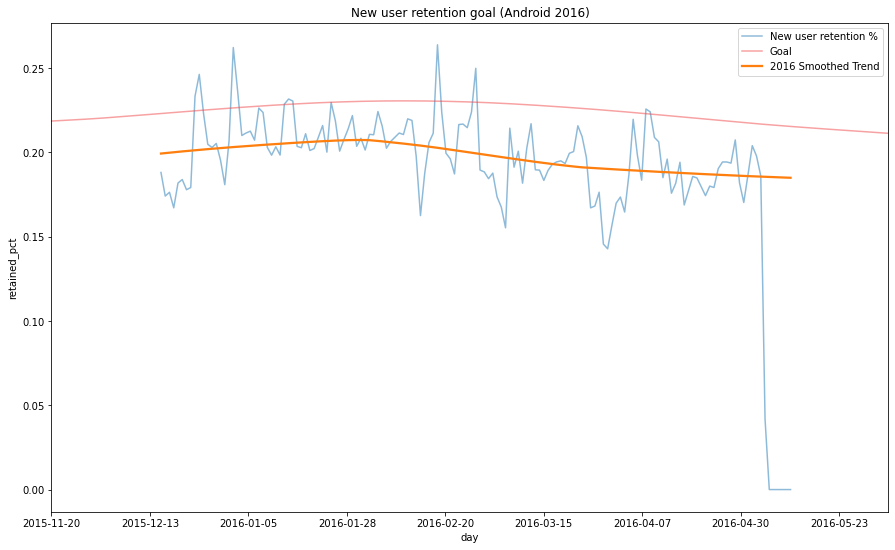

In [334]:
android_dnum = android[(android['day'] >= first) & (android['day'] < last)]
android_dnum.loc[:,'day'] = android_dnum['day'].astype('int')
goals = android_loprd[android_loprd['day'] < last]
goals.loc[:,'day'] = goals['day'].astype('int')

fig, ax = plt.subplots(figsize=(15,9))
sns.lineplot(data=android_dnum, x='day', y='retained_pct', ax=ax, alpha=.5)
sns.lineplot(data=goals, x='day', y='predicted_a', ax=ax, alpha=.5, color='#f04546')
sns.regplot(data=android_dnum, x='day', y='retained_pct', lowess=True, scatter=False, ax=ax);
ax.set_xlim(1.448e18, 1.465e18)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
#plt.xticks(rotation=15)
plt.legend(['New user retention %', 'Goal','2016 Smoothed Trend'])
plt.title('New user retention goal (Android 2016)');

## iOS

In [335]:
ios = df[(df['platform'] == 'ios')
         & (df['day'] < max_d)
         & (df['day'] > pd.to_datetime('2014-09-20'))]

In [336]:
ios_lo = lowess(ios['retained_pct'].to_numpy(), ios['day'].astype(np.int).to_numpy(), frac=.3)
lowess_x = list(zip(*ios_lo))[0]
lowess_y = list(zip(*ios_lo))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)

In [337]:
ios_loprd = pd.DataFrame({
    'day': new_data_forward,
    'year': new_data_forward.dt.year,
    'predicted': f(new_data.astype(np.int))
})
ios_loprd = ios_loprd.sort_values(by='day')
ios_loprd['predicted_a'] = ios_loprd['predicted'] + 0.01

In [341]:
# Summary
ios_loprd.query('year == "2016"')['predicted'].describe()

count    366.000000
mean       0.192153
std        0.008907
min        0.182546
25%        0.185293
50%        0.187756
75%        0.199832
max        0.208708
Name: predicted, dtype: float64

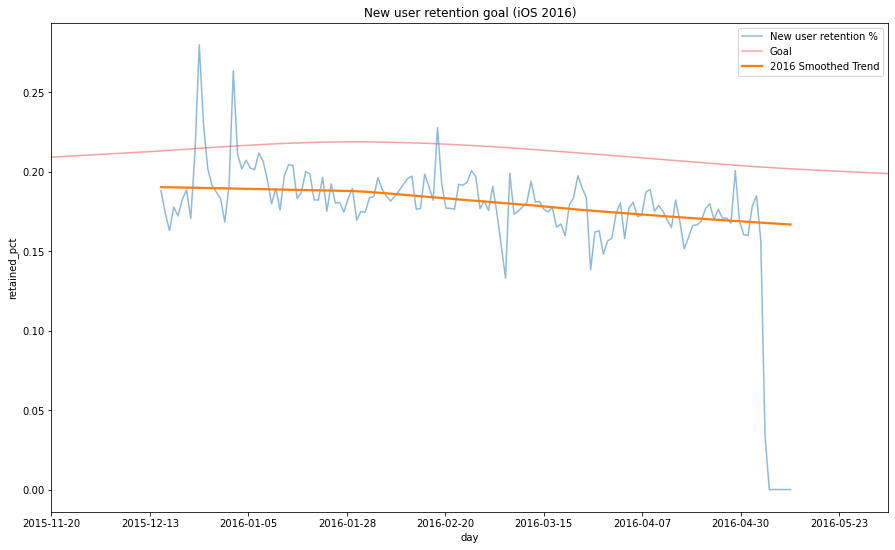

In [343]:
ios_dnum = ios[(ios['day'] >= first) & (ios['day'] < last)]
ios_dnum.loc[:,'day'] = ios_dnum['day'].astype('int')
ios_goals = ios_loprd[ios_loprd['day'] < last]
ios_goals.loc[:,'day'] = ios_goals['day'].astype('int')

fig, ax = plt.subplots(figsize=(15,9))
sns.lineplot(data=ios_dnum, x='day', y='retained_pct', ax=ax, alpha=.5)
sns.lineplot(data=ios_goals, x='day', y='predicted_a', ax=ax, alpha=.5, color='#f04546')
sns.regplot(data=ios_dnum, x='day', y='retained_pct', lowess=True, scatter=False, ax=ax);
ax.set_xlim(1.448e18, 1.465e18)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
#plt.xticks(rotation=15)
plt.legend(['New user retention %', 'Goal','2016 Smoothed Trend'])
plt.title('New user retention goal (iOS 2016)');

## Quarters

In [351]:
android_loprd['quarter'] = android_loprd['day'].apply(lambda x: x.quarter)
ios_loprd['quarter'] = ios_loprd['day'].apply(lambda x: x.quarter)

In [356]:
android_loprd.groupby(['year', 'quarter']).agg({'predicted_a': 'mean'}).add(0.01).mul(100)

predicted_a
year quarter             
2015 3          22.268280
     4          22.861572
2016 1          23.876836
     2          22.503356
     3          21.640170
     4          22.204492
2017 1          21.945816
     2          20.806173

In [357]:
ios_loprd.groupby(['year', 'quarter']).agg({'predicted_a': 'mean'}).add(0.01).mul(100)

predicted_a
year quarter             
2015 3          21.130920
     4          21.849209
2016 1          22.615535
     2          21.174852
     3          20.378038
     4          20.707582
2017 1          20.227788
     2          19.062803

In [358]:
ios_loprd['platform'] = 'ios'
android_loprd['platform'] = 'android'

In [484]:
total = pd.concat([ios_loprd, android_loprd])[['day', 'predicted_a', 'platform']]
total = total[total['day'] >= '2016-01-04']

In [485]:
main = pd.read_csv('/MW/mobile_new_goals_2016.csv', parse_dates=['week'])

In [383]:
from pandas.tseries.offsets import Week

In [486]:
main['week'] = pd.to_datetime(main['week'])
total['week'] = pd.to_datetime(total['day']).dt.to_period('W-SUN').dt.start_time # floor date week
total.rename({'predicted_a': 'retention'}, axis='columns', inplace=True)

In [488]:
pd.merge(total, main, on=['week', 'platform'], how='outer')

,day,retention,platform,week,mw,wau,mw_a,wau_a
0,2016-01-04 05:49:12,0.216387,ios,2016-01-04,646357688.0,3293243.0,646357688.0,3293243.0
1,2016-01-05 05:49:12,0.216541,ios,2016-01-04,646357688.0,3293243.0,646357688.0,3293243.0
2,2016-01-06 05:49:12,0.216691,ios,2016-01-04,646357688.0,3293243.0,646357688.0,3293243.0
3,2016-01-07 05:49:12,0.216838,ios,2016-01-04,646357688.0,3293243.0,646357688.0,3293243.0
4,2016-01-08 05:49:12,0.216981,ios,2016-01-04,646357688.0,3293243.0,646357688.0,3293243.0
...,...,...,...,...,...,...,...,...
985,2017-05-08 05:49:12,0.194763,android,2017-05-08,NaN,NaN,NaN,NaN
986,2017-05-09 05:49:12,0.194562,android,2017-05-08,NaN,NaN,NaN,NaN
987,2017-05-10 05:49:12,0.194361,android,2017-05-08,NaN,NaN,NaN,NaN
988,2017-05-11 05:49:12,0.194160,android,2017-05-08,NaN,NaN,NaN,NaN


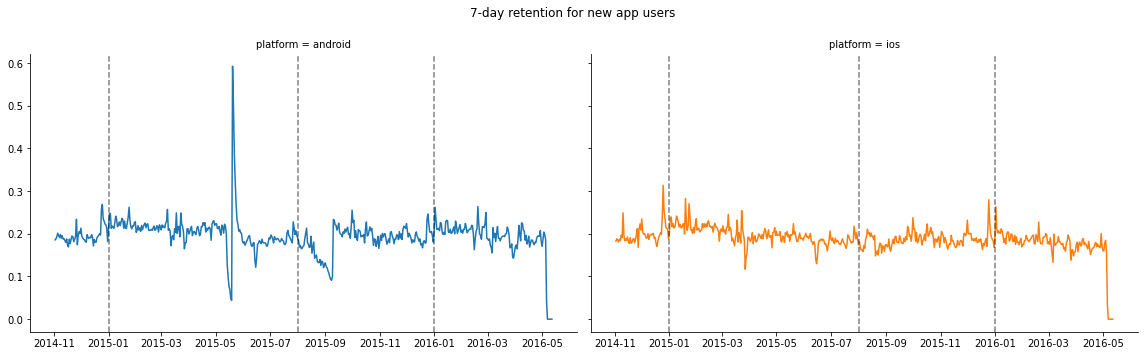

In [6]:
grid = sns.FacetGrid(
    df[(df['day'] < max_d) 
       & (df['day'] > pd.to_datetime('2014-11-01'))],
    col='platform',
    hue='platform',
    # palette='viridis',
    height=5,
    aspect=1.6,
    margin_titles=True,
)
grid.map(sns.lineplot, 'day', 'retained_pct')
for dt in list(filter(lambda x: x.month in (1,8),
                 pd.date_range('2015-01-01', periods=15, freq=pd.offsets.MonthBegin()))):
    grid.map(plt.axvline, x=dt, ls='--', c='k', alpha=.5)

grid.fig.subplots_adjust(top=0.85)
grid.fig.suptitle('7-day retention for new app users');

## Predict ARIMA

In [8]:
android_full = df[(df['platform'] == 'android') & (df['day'] < max_d)]
android = df[(df['platform'] == 'android')
             & (df['day'] < max_d)
             & (df['day'] > pd.to_datetime('2014-09-20'))]

In [9]:
import statsmodels.api as sm
from scipy.interpolate import interp1d

In [10]:
new_data = np.append(android['day'], pd.date_range(max_d, periods=230, freq='D'))

In [11]:
lowess = sm.nonparametric.lowess

In [12]:
# lowess will return our "smoothed" data with a y value for at every x-value
android_lo = lowess(df['retained_pct'].to_numpy(), df['day'].astype(np.int).to_numpy(), frac=.3)

In [13]:
lowess_x = list(zip(*android_lo))[0]
lowess_y = list(zip(*android_lo))[1]
# run scipy's interpolation
f = interp1d(lowess_x, lowess_y, bounds_error=False)

In [14]:
android_loprd = pd.DataFrame({
    'day': new_data,
    'predicted': f(new_data.astype(np.int))
})
#android_loprd['predicted'] = f(new_data.astype(np.int)) 
android_loprd = pd.concat([android_loprd, android['retained_pct'].reset_index(drop=True)], axis=1) \
                                        .rename({'retained_pct': 'actual'}, axis='columns')
#android_loprd['actual'] = android['retained_pct']
#android_loprd.loc[android_loprd['day'] < max_d, 'actual'] = android['retained_pct']

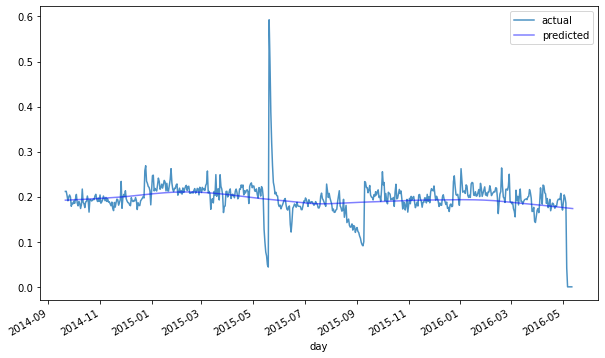

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
android_loprd.plot(x='day', y='actual', ax=ax, alpha=0.8)
android_loprd.plot(x='day', y='predicted', ax=ax, alpha=0.5, color='blue');

In [16]:
android_curve_pred = android_loprd[~android_loprd['actual'].isna()]

In [17]:
android_curve_pred.loc[:, 'day'] = (android_curve_pred['day'] + pd.to_timedelta('1Y')).astype('datetime64[D]')

/Users/popov/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [18]:
android_curve_pred

,day,predicted,actual
0,2016-02-21,0.210354,0.218091
1,2016-08-17,0.186240,0.167226
2,2016-04-06,0.203438,0.205620
3,2015-11-20,0.198641,0.187327
4,2016-04-01,0.204519,0.204483
...,...,...,...
595,2016-12-11,0.193107,0.204380
596,2016-06-09,0.190436,0.172527
597,2016-05-21,0.193771,0.387753
598,2016-01-05,0.207032,0.218329


In [19]:
bar = pd.merge(android_curve_pred, android[['day', 'retained_pct']], on='day')

In [20]:
bar['add'] = bar['retained_pct'] - bar['actual']
bar['predicted_2'] = bar['predicted']

In [21]:
mask = bar['day'] > pd.to_datetime('2016-03-01')
bar.loc[mask, 'predicted_2'] = bar.loc[mask, 'predicted_2'] - 0.02

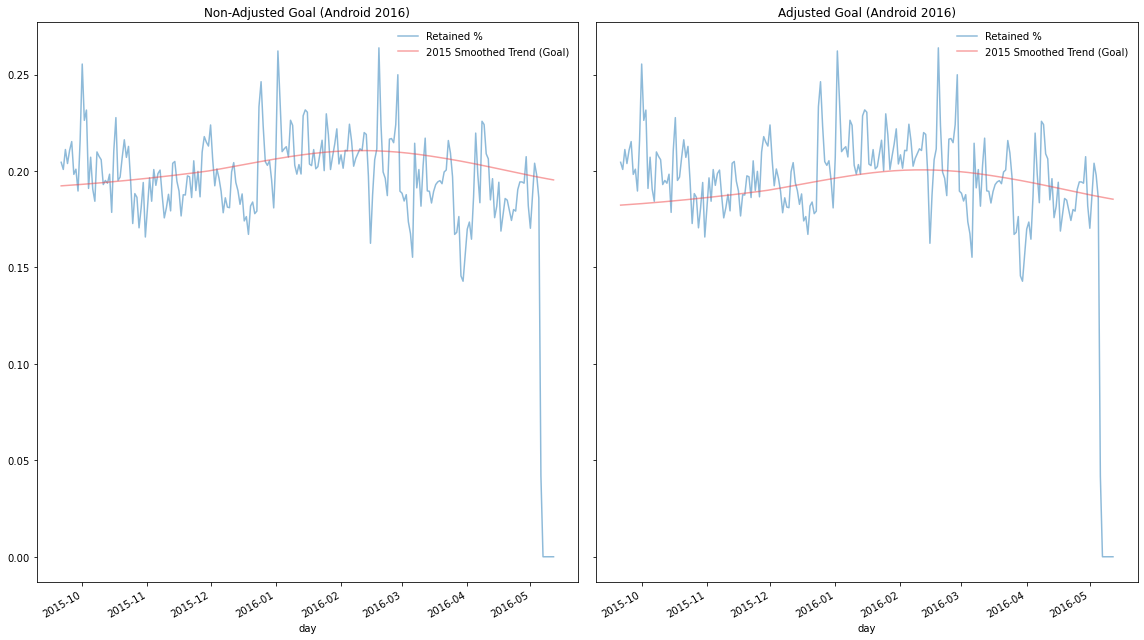

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(16,9), sharex=True)
bar.plot(x='day',
         y='retained_pct',
         ax=axes[0],
         alpha=0.5,
         #color='k',
         label='Retained %')
bar.plot(x='day',
         y='predicted',
         ax=axes[0],
         alpha=0.5,
         color='#f04546',
         label='2015 Smoothed Trend (Goal)')
bar['predicted_adj'] = bar['predicted'] - 0.01
bar.plot(x='day',
         y='retained_pct',
         ax=axes[1],
         alpha=0.5,
         #color='k',
         label='Retained %')
bar.plot(x='day',
         y='predicted_adj',
         ax=axes[1],
         alpha=0.5,
         color='#f04546',
         label='2015 Smoothed Trend (Goal)')
axes[0].get_shared_y_axes().join(*axes)
axes[1].set_yticklabels([])
axes[0].set_title('Non-Adjusted Goal (Android 2016)')
axes[1].set_title('Adjusted Goal (Android 2016)')
fig.tight_layout()
legend = [x.legend(frameon=False) for x in axes];

In [38]:
from statsmodels.tsa.seasonal import STL

In [56]:
from tbats import TBATS, BATS

In [75]:
android_raw_series = android.loc[android['day'] >= pd.to_datetime('2014-10-01'), ['day', 'retained_pct']]

In [60]:
estimator = TBATS(seasonal_periods=(7, 30, 365.25))
model = estimator.fit(android_raw_series.set_index('day'))

In [62]:
android_spline = estimator.fit(android.set_index('day')['retained_pct'])

In [74]:
android_spline_forecast = pd.DataFrame(android_spline.forecast(steps=60),
                                       pd.date_range('2016-05-06', periods=60, freq='D'),
                                       columns=['predicted'])

In [178]:
st = pd.concat([pd.to_datetime(android['day']),
                android['retained_pct'].rolling(window=2).mean()], axis=1)

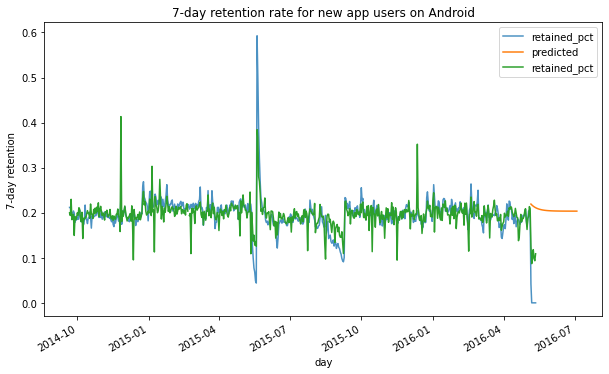

In [185]:
fig, ax = plt.subplots(figsize=(10,6))
android.plot(x='day', y='retained_pct', ax=ax, alpha=0.8)
android_spline_forecast.plot(ax=ax, label='Predicted Trend')
pd.concat([android['day'].astype('datetime64[D]'),
                android['retained_pct'].rolling(window=2).mean()], axis=1) \
                                       .plot(x='day', ax=ax, label='Smoothed Trend')
ax.set_ylabel('7-day retention')
ax.set_title('7-day retention rate for new app users on Android');